In [1]:
from itertools import chain

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords', quiet=True)
# nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd

import seaborn as sns

from sklearn import feature_extraction
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as ms
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import string

<h3>Read in data, add header row and display first 5 rows:</h3>

In [2]:
text_df = pd.read_csv('../input/website-classification/website_classification.csv')
text_df.head(5)

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


<h3>We are deleting two unnecessary columns from the dataframe: <I>'Unnamed: 0'</I> and <I>'website_url'</I></h3>

In [3]:
del text_df['Unnamed: 0'], text_df['website_url']
text_df.head(5)

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel


<h4>Unique categories:</h4>

In [4]:
categories = list(text_df['Category'].unique())
categories

['Travel',
 'Social Networking and Messaging',
 'News',
 'Streaming Services',
 'Sports',
 'Photography',
 'Law and Government',
 'Health and Fitness',
 'Games',
 'E-Commerce',
 'Forums',
 'Food',
 'Education',
 'Computers and Technology',
 'Business/Corporate',
 'Adult']

In [5]:
text_df.shape

(1408, 2)

<h4>We have 1408 rows and 4 columns</h4>

In [6]:
cleaned_website_text = list(text_df['cleaned_website_text'].unique())
len(cleaned_website_text)

1375

<h4>There are 1375 unique rows</h4>

<h3>Number of rows by category</h3>

In [7]:
text_df['Category'].value_counts()

Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
News                                96
Health and Fitness                  96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: Category, dtype: int64

<h3>Number of <B><I>unique</I></B> rows by category</h3>

In [8]:
cat_unique_val = {}

for category in categories:
    mask = text_df['Category'] == category
    list_length = len(list(text_df[mask]['cleaned_website_text'].unique()))
    cat_unique_val.update({category: list_length})

    cat_unique_val

<h3>Sort dictionary in descending order</h3>

In [9]:
cat_unique_val_sorted = {}
sorted_keys = sorted(cat_unique_val, key=cat_unique_val.get)

for w in list(reversed(sorted_keys)):
    cat_unique_val_sorted[w] = cat_unique_val[w]
    
# cat_unique_val_sorted
cat_unique_val_sorted

{'Education': 114,
 'Business/Corporate': 108,
 'Travel': 106,
 'Streaming Services': 104,
 'E-Commerce': 101,
 'Sports': 100,
 'Games': 98,
 'Food': 92,
 'News': 92,
 'Computers and Technology': 90,
 'Health and Fitness': 89,
 'Photography': 87,
 'Law and Government': 83,
 'Social Networking and Messaging': 79,
 'Adult': 16,
 'Forums': 16}

<h3>Dropping duplicate rows from each category</h3>

In [10]:
text_df = text_df.drop_duplicates()

In [11]:
text_df.shape

(1375, 2)

<h3>Text cleaning</h3>

<p>Removing stopwords and punctuation from <B><I>"cleaned_website_text" column</I></B></p>

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
regular_punct = list(string.punctuation)

<h3>According to title text in our dataframe column is cleared, but in any case we will aplly function to remove posssible stopwords and punctuation</h3>

In [14]:
text_df['cleaned_website_text']

0       official site good hotel accommodation big sav...
1       expedia hotel book sites like use vacation wor...
2       tripadvisor hotel book sites like previously d...
3       cheap flights search compare flights momondo f...
4       bot create free account create free account si...
                              ...                        
1403    old nude women porn mature granny sex horny ol...
1404    bdsm cams bdsm chat bondage cams free bdsm vid...
1405    porno dvd online european porn dvd cheap adult...
1406    anal dream house anal dream house anal dream h...
1407    world sex news daily sex news adult news eroti...
Name: cleaned_website_text, Length: 1375, dtype: object

In [15]:
def text_preprocessing(x):
    filtered_sentence = []
    word_tokens = word_tokenize(x)
    
    for w in word_tokens:
        if w not in chain(stop_words, regular_punct):
            # we make sure that all words are written in lowercase
            filtered_sentence.append(w.lower())
    
    # Converting a list of strings back to a string
    filtered_sentence = " ".join(filtered_sentence)
    return filtered_sentence

In [16]:
text_df['cleaned_website_text'] = text_df['cleaned_website_text'].apply(text_preprocessing)

In [17]:
text_df['cleaned_website_text']

0       official site good hotel accommodation big sav...
1       expedia hotel book sites like use vacation wor...
2       tripadvisor hotel book sites like previously d...
3       cheap flights search compare flights momondo f...
4       bot create free account create free account si...
                              ...                        
1403    old nude women porn mature granny sex horny ol...
1404    bdsm cams bdsm chat bondage cams free bdsm vid...
1405    porno dvd online european porn dvd cheap adult...
1406    anal dream house anal dream house anal dream h...
1407    world sex news daily sex news adult news eroti...
Name: cleaned_website_text, Length: 1375, dtype: object

<h3>Preprocessing the data</h3>

<h4>One of the simplest
methods of encoding text data is by word count: For each phrase, you count the
number of occurrences of each word within it. In scikit-learn, this is easily done using
CountVectorizer:</h4>

In [18]:
counts = feature_extraction.text.CountVectorizer()
X = counts.fit_transform(text_df['cleaned_website_text'].values)
X.shape

(1375, 59995)

In [19]:
y = text_df['Category'].values

<h4>Training a normal Bayes classifier</h4>

In [20]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model_naive = naive_bayes.MultinomialNB()
model_naive.fit(X_train, y_train)

MultinomialNB()

In [22]:
model_naive.score(X_train, y_train)

0.980909090909091

In [23]:
model_naive.score(X_test, y_test)

0.88

<h4><B><I>We got 88% accuracy on the test set</I></B></h4>

<h4>Confusion matrix</h4>

In [24]:
confusion_matrix(y_test, model_naive.predict(X_test))

array([[ 1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  1,  1,  0,  0,  0,  0,  1,  2,  2,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0, 25,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 24,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 15,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  1,  0,  1,  0,  0,  0,  0,  6,  0,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

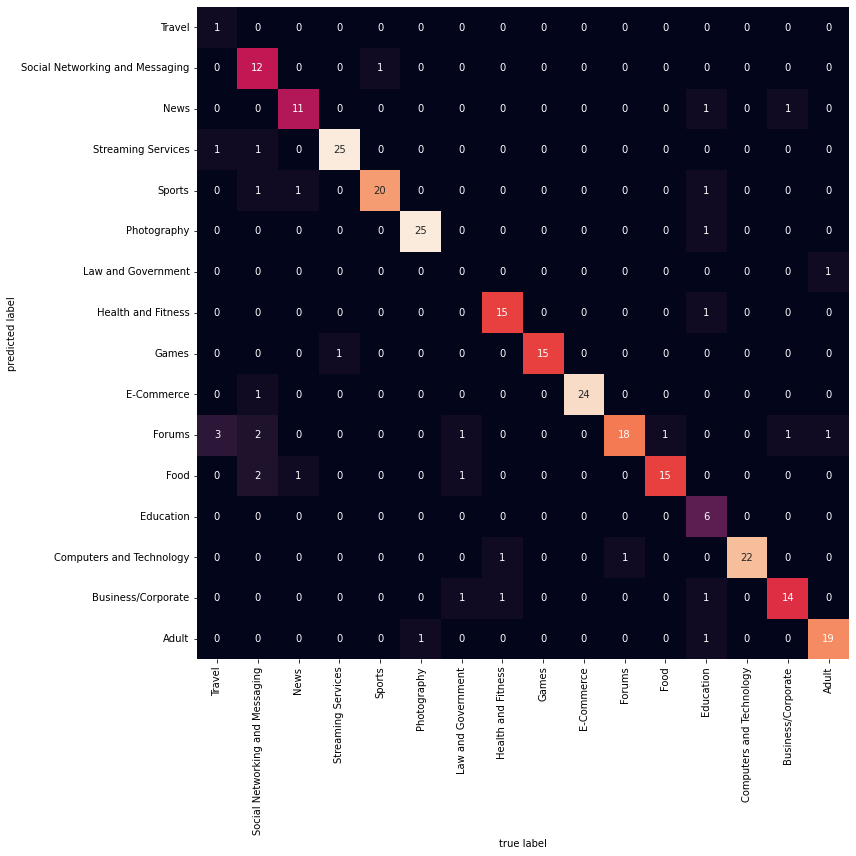

In [25]:
mat = confusion_matrix(y_test, model_naive.predict(X_test))
plt.figure(figsize=(18,12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories,
            yticklabels=categories
           )
plt.xlabel('true label')
plt.ylabel('predicted label');